# Predicting the revenue of the movies based on budget

### Introduction

The entertainment industry has always been a profitable field, especially movies. However, with great profit comes great investment. Most modern-day movies require a budget of around 100 million dollars(1). It is crucial for investors/directors to have a general idea of how much profit they can make based on their investment. Thus, this project centers around studying the profitability of a movie before it is released, predicting revenues based on budget using Knn regression (since most movies fall under a general range of budget and there are rarely extreme outliers)

The question we will try to answer with our project is what is the revenue of a movie based on budget. The data set, which consists of 5000 movies from TMDB, will be separated into training and testing sets. Using budget as the predictor, the prediction of test set revenue will be made. 

In the data set “TMDB 5000 Movie Dataset” (from "https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata"), revenues, budget, popularity are recorded for the 5000 movies listed in an excel format. Other columns are listed/included in the data set as well, however because they are written in json or not a significant predictor to the revenue, those columns will be filtered out. Revenues is defined as the total box income of the movie; budget is defined as the funding used for the production; Popularity numbers are built according to the TMDB model which consists of number of votes for the day, number of views for the day, number of users who marked it as a "favourite" for the day, Number of users who added it to their "watchlist" for the day, release date, number of total votes, and previous days score. We will discuss and analyze the correlation of each variable with revenue below.



### Methods & Results:

We used functions from the tidyverse library to manipulate data frames and tibbles. `repr` is used to resize plots contained in this notebook, such as an “Accuracy vs K” graph. `tidymodels` is a package used for statistical and modeling analysis. `GGally` extends ggplot2 by adding several functions to reduce the complexity of combining geoms with transformed data. `cowplot` is used to generate the function `plot-grid` to easily compare plots.

In [2]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(infer)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

**DATA CLEANING AND EXPLORATORY ANALYSIS**

Here we download the data from the server from the url, and we saved it as "Revenue.csv" under the /DSCI-100-Project-Group25/Revenue.csv location.


In [3]:
# Getting Dataset from Web
url <- "https://raw.githubusercontent.com/rehan13/DSCI-100-Project-Group25/master/tmdb_5000_movies.csv"
download.file(url, destfile = "Revenue.csv")


Since we already downloaded the revenue file, we now can read it using `read_csv` since it is under the csv format. The data sets does not contain any `NA` value and have column names, so no other arguements are necessary. 

In [4]:
# Raw data being read from the web
Revenue_data <- read_csv("Revenue.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  budget = col_double(),
  id = col_double(),
  popularity = col_double(),
  release_date = col_date(format = ""),
  revenue = col_double(),
  runtime = col_double(),
  vote_average = col_double(),
  vote_count = col_double()
)

See spec(...) for full column specifications.



As we can see, the data contains cells written in json, which is outside of the class criteria and difficult to understand. Predictors written in json such as spoken language, production countries and genre also have little correlation with the revenue. So we filtered out the unnecessary columns in the code below using `select` and `filter`.

In [5]:
# Exploratory Data
Revenue_Data_Particulars <- select(Revenue_data, vote_average, budget, runtime, popularity, revenue)%>%
filter(revenue > 0, budget > 0)

Revenue_Data_Particulars

vote_average,budget,runtime,popularity,revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.2,2.37e+08,162,150.4376,2787965087
6.9,3.00e+08,169,139.0826,961000000
6.3,2.45e+08,148,107.3768,880674609
⋮,⋮,⋮,⋮,⋮
7.4,20000,111,0.212443,99000
6.9,7000,77,23.307949,424760
6.6,220000,81,14.269792,2040920


The data set used contain 5000 data points, and since we are using knn-nearest neighbor regression, a large data set will take way too long to train. A more practical approach would be to make measurements for a sample, and we will be using statistical inference technique to compute a sample estimate. 

We will visualize the distribution of the revenue population.

In [28]:
pop_dist <- ggplot(Revenue_Data_Particulars, aes(x = revenue)) + 
   geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
   labs(x = "revenue of 5000 movies", y = "Count") +
   ggtitle("Population distribution of revenue (n = 5000)")

budget_dist <- ggplot(Revenue_Data_Particulars, aes(x = budget)) + 
   geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
   labs(x = "revenue of 5000 movies", y = "Count") +
   ggtitle("Population distribution of budget (n = 5000)")

In [29]:
pop_parameters <- Revenue_Data_Particulars %>%
summarize(pop_mean = mean(revenue), pop_med = median(revenue), pop_sd = sd(revenue))
pop_parameters

budget_parameters <- Revenue_Data_Particulars %>%
summarize(bud_mean = mean(budget), bud_med = median(budget), bud_sd = sd(budget))
budget_parameters

pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
121242957,55184721,186302864


bud_mean,bud_med,bud_sd
<dbl>,<dbl>,<dbl>
40654445,2.5e+07,44396742


We use the `sample_n` to take a random sample of size 2000, and set the seed as 2021 to make the results reproducible.

In [30]:
set.seed(16) #seed set to make the result reproducible
Rev_sample <- sample_n(Revenue_Data_Particulars, size = 2000)

Rev_sample

vote_average,budget,runtime,popularity,revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.4,52500000,127,57.37434,179213434
6.8,15000000,103,53.69868,108286421
5.9,55000000,97,38.06168,152263880
⋮,⋮,⋮,⋮,⋮
6.1,1.6e+07,100,18.79022,318982
6.9,2.0e+07,107,44.56661,5359645
6.6,5.0e+07,112,37.06925,260095987


We will then look at the mean of the new sample and determine if this sample is a good representation of the whole set by using `summarize` function. 

In [31]:
sample_estimates_rev <- Rev_sample %>%
summarize(sample_2_mean = mean(revenue), sample_2_med = median(revenue),sample_2_sd = sd(revenue))
sample_estimates_rev

sample_estimates_bud <- Rev_sample %>%
summarize(sample_2_mean = mean(budget), sample_2_med = median(budget),sample_2_sd = sd(budget))
sample_estimates_bud

sample_2_mean,sample_2_med,sample_2_sd
<dbl>,<dbl>,<dbl>
121752691,54941513,187058853


sample_2_mean,sample_2_med,sample_2_sd
<dbl>,<dbl>,<dbl>
40171107,2.5e+07,43653435


The mean, median and standard deviation showed that the sample is a reasonable representation of the whole data set. The sample seem to be a good representation of the original full-sized data. The shapes of the distribution graphs are both right skewed with a center located towards 0e+00. Thus, we will be using the 2000 data sample to train/test the model.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



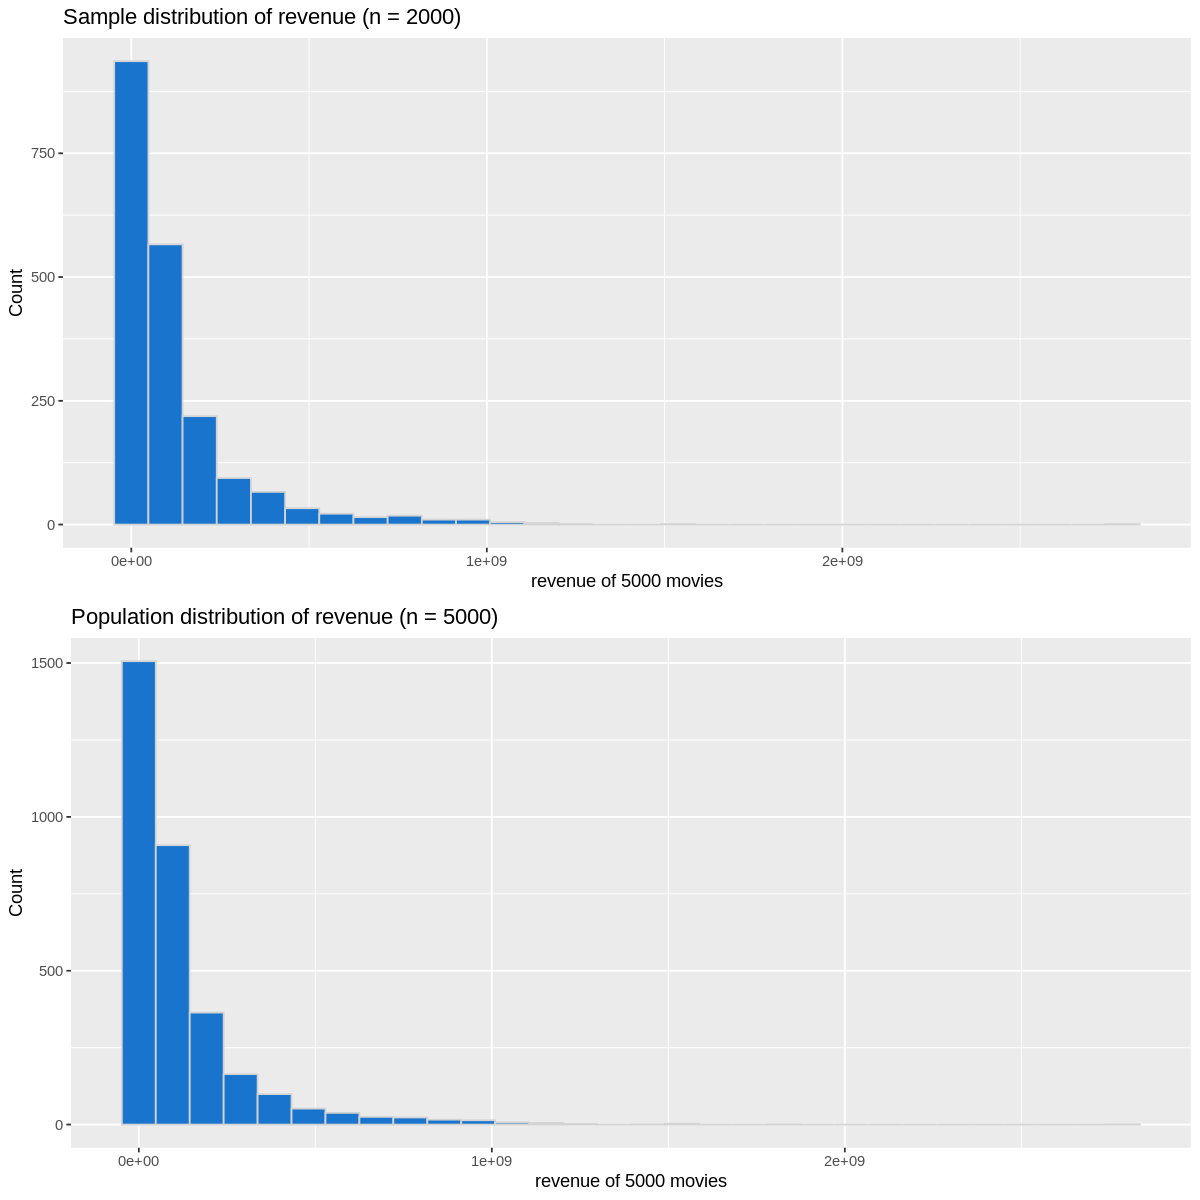

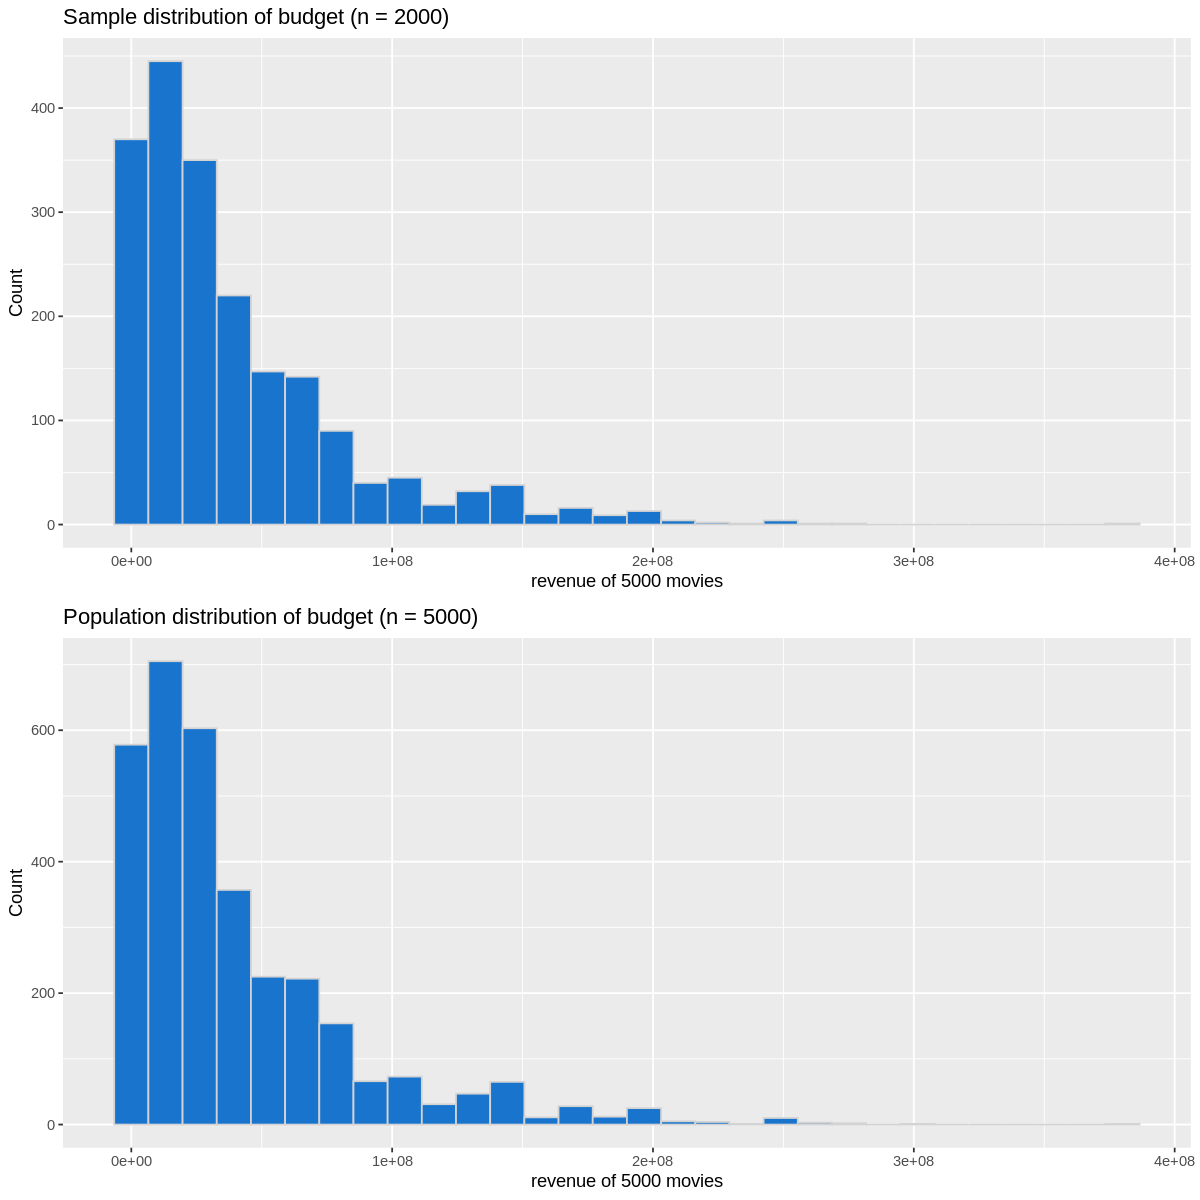

In [32]:
rev_dist_2000 <- ggplot(Rev_sample, aes(x = revenue)) + 
   geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
   labs(x = "revenue of 5000 movies", y = "Count") +
   ggtitle("Sample distribution of revenue (n = 2000)")

bud_dist_2000 <- ggplot(Rev_sample, aes(x = budget)) + 
   geom_histogram(fill = "dodgerblue3", color = "lightgrey") +
   labs(x = "revenue of 5000 movies", y = "Count") +
   ggtitle("Sample distribution of budget (n = 2000)")

plot_grid(rev_dist_2000, pop_dist, ncol = 1)

plot_grid(bud_dist_2000, budget_dist,ncol = 1)

As of now, we have a single giant data frame consisting of all the data of TMDB movie. If we pass all of the revenue data into our model, we would not have any data to use as a measure of how accurate the model is. If we use the data that we have used to train the model before, the model will recognize that data because it has “seen” it before and will most likely produce a faulty accuracy that is higher than reality.

Therefore, to allow a fair process of measuring the model’s accuracy, we must calculate its accuracy based on how accurate it is at predicting revenues that it hasn’t “seen” before. To do this, we split the data into training and testing datasets and only use the training dataset to create our regression model. By doing so, we will have a set of data that the machine learning hasn't seen before.

To do this, we will use the golden ratio which is a 75-25% ratio of training and testing datasets respectively. The strata statement can shuffle and ensure the data is not split unrepresentatively.

To make sure that this process is replicable, we use set.seed().

In [33]:
# Train / Test Data
set.seed(15)
revenue_split <- initial_split(Rev_sample, prop = 0.75, strata = revenue)
revenue_train <- training(revenue_split)
revenue_test <- testing(revenue_split)

Below we use `ggpairs` to analyze the correlation between revenues and the predictors "vote_average", "budget", "runtime", and "popularity". 

As we can see, the correlation between budget and revenue is the strongest, and it is also our subject of interest since we are trying to predict revenues based off budget which can directly influence the profit of the investors. All the other predictos have little to no correlation with revenues. Other predictos such as popularity are only relevant or in-existence after the production of the movie which are also not reliable predictors to understand revenue before the investment. For example, Popularity numbers are built according to the TMDB model which consists of number of votes for the day, number of views for the day, number of users who marked it as a "favourite" for the day, Number of users who added it to their "watchlist" for the day, release date, number of total votes, and previous days score (which are only recorded after the movie is produced).

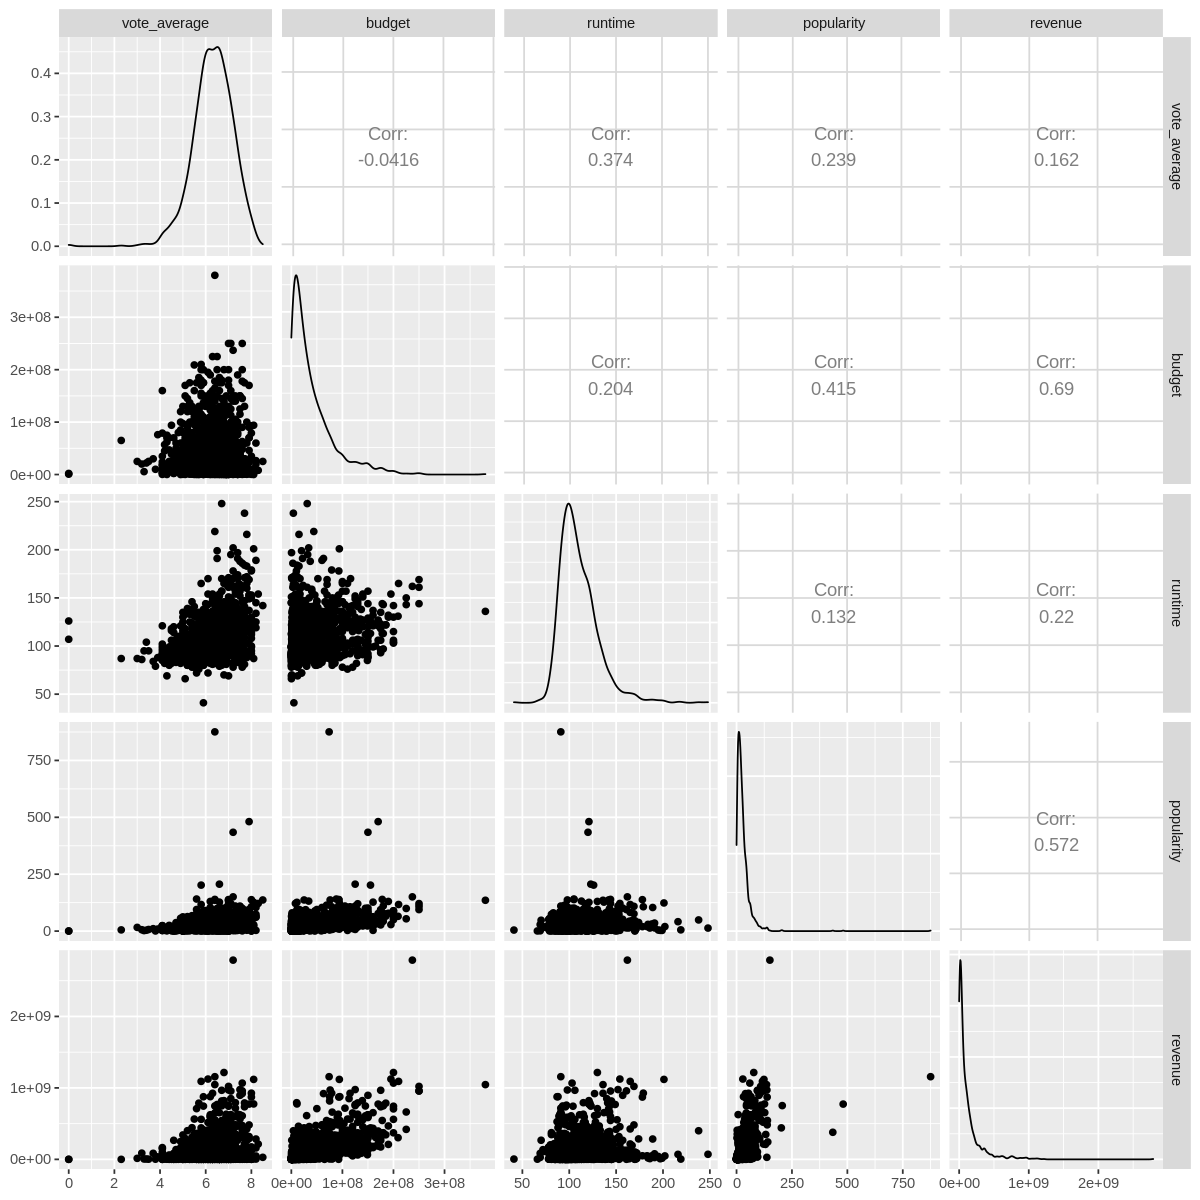

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)
relationship_revenue <- ggpairs(revenue_train)
relationship_revenue 

**Knn-nearest neighbor regression model training**

First, we created a recipe using the `recipe` functions with the variables of interest (budget) using the training dataset and assign your answer to an object named `revenue_recipe`. We also added scaling `(step_scale)` and centering `(step_center)` steps for all of the predictors so that they each have a mean of 0 and standard deviation of 1 (Since we only have one predictor, the standarization is for practice only).

In [35]:
# create recipe
revenue_recipe <- recipe(revenue ~ budget, data = revenue_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

If we split our overall training data once, our best parameter choice will depend strongly on our luck (since whatever data that lands in the validation set is random). By using multiple different train / validation splits, a better accuracy/representation of the data can be estimated, which will lead to a better choice of the number of neighbours $K$ for the overall set of training data. 

In cross-validation, we split our overall training data into $x$ evenly-sized chunks, and then iteratively use 1 chunk as the validation set and combine the remaining $x−1$ chunks as the **training set.**

We decided to split our overall training data up in multiple different ways using `vfold_cv`, train and evaluate a regression model for each split, and then choose the parameter based on all of the different results. The v value is set as 5 which is the number of folds, and we set **revenue** as the strata arguement.  


In [36]:
# 5 fold cross-validation 
revenue_vfold <- vfold_cv(revenue_train, v = 5, strata = revenue)

We created **revenue_spec** using the `nearest_neighbor` function.

In order to improve our regression model, we need to change the parameter: number of neighbours, $K$. Since cross-validation helps us evaluate the accuracy of our model, we can use cross-validation to pick the value of $K$ that gives us the best accuracy. 

Using `tune()` in `tidymodels` package, each parameter in the model can be altered/attempted rather than given a specific value. 


In [37]:
# create KNN model
revenue_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

using `workflow`, we can chain together multiple data analysis steps without a lot of otherwise necessary code for intermediate steps. We use the **revenue_recipe** and **revenue_spec** we have created previously in the workflow. 

In [38]:
# fitting the data in knn model
revenue_wkflw <- workflow() %>%
  add_recipe(revenue_recipe) %>%
  add_model(revenue_spec)

revenue_wkflw

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We can use `tibble` to create a set of values we will be using for the `grid` arguement (the range of parameter we will be testing). Here, we indicated the $k$ value to range from 1 to 500, and step by 2. 

In [39]:
# Setting the gridvals.
gridvals <- tibble(neighbors = seq(from = 1, to = 500, by = 2))

We can then use the `tune_grid` function to fit the model for each value in a range of parameter values. For the resamples argument, we input the cross-validation **revenue_vfold** we created earlier. The grid argument specifies that the tuning should try  𝑋  amount of values of the number of neighbors  𝐾  when tuning, we input the **gridvals** object we created earlier to indicate the range of parameters we would like to try. 

We then used `filter` to only list out rmse (which represent $RMSPE$: **root mean square prediction error**) to use to evaluate for the best k value.

In [40]:
# results of the model.
revenue_results <- revenue_wkflw %>%
  tune_grid(resamples = revenue_vfold, grid = gridvals) %>%
  collect_metrics() %>%
  filter(.metric == "rmse")

revenue_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,164271285,5,12593514,Model001
3,rmse,standard,152384038,5,9326167,Model002
5,rmse,standard,144410047,5,9072417,Model003
⋮,⋮,⋮,⋮,⋮,⋮,⋮
495,rmse,standard,161078223,5,11723212,Model248
497,rmse,standard,161174708,5,11714435,Model249
499,rmse,standard,161235588,5,11712518,Model250


Here we can see neighbor $k = 25$ gives us the minimum $RMSPE$.  

In [41]:
revenue_min <- revenue_results %>%
  filter(mean == min(mean))

revenue_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,rmse,standard,136531918,5,9567628,Model013


We assigned the best $k$ to `k_min`, and use the best k value to recreate our model. 

In [42]:
k_min <- revenue_min %>%
        pull(neighbors)

revenue_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
         set_engine("kknn") %>%
         set_mode("regression")

revenue_best_fit <- workflow() %>%
         add_recipe(revenue_recipe) %>%
         add_model(revenue_best_spec) %>%
         fit(data = revenue_train)

Finally, we will pass the testing dataset into our final regression model. The model will predict the revenue using the `predict()` function function, we will compare its predictions with the actual labels.

In [43]:
revenue_summary <- revenue_best_fit %>%
          predict(revenue_test) %>%
          bind_cols(revenue_test) %>%
          metrics(truth = revenue, estimate = .pred)
revenue_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.316789e+08
rsq,standard,4.861122e-01
mae,standard,7.833645e+07


At last, we visualize our prediction using `ggplot` functions to evaluate if our model is overfitting, underfitting or a good fit for our target.

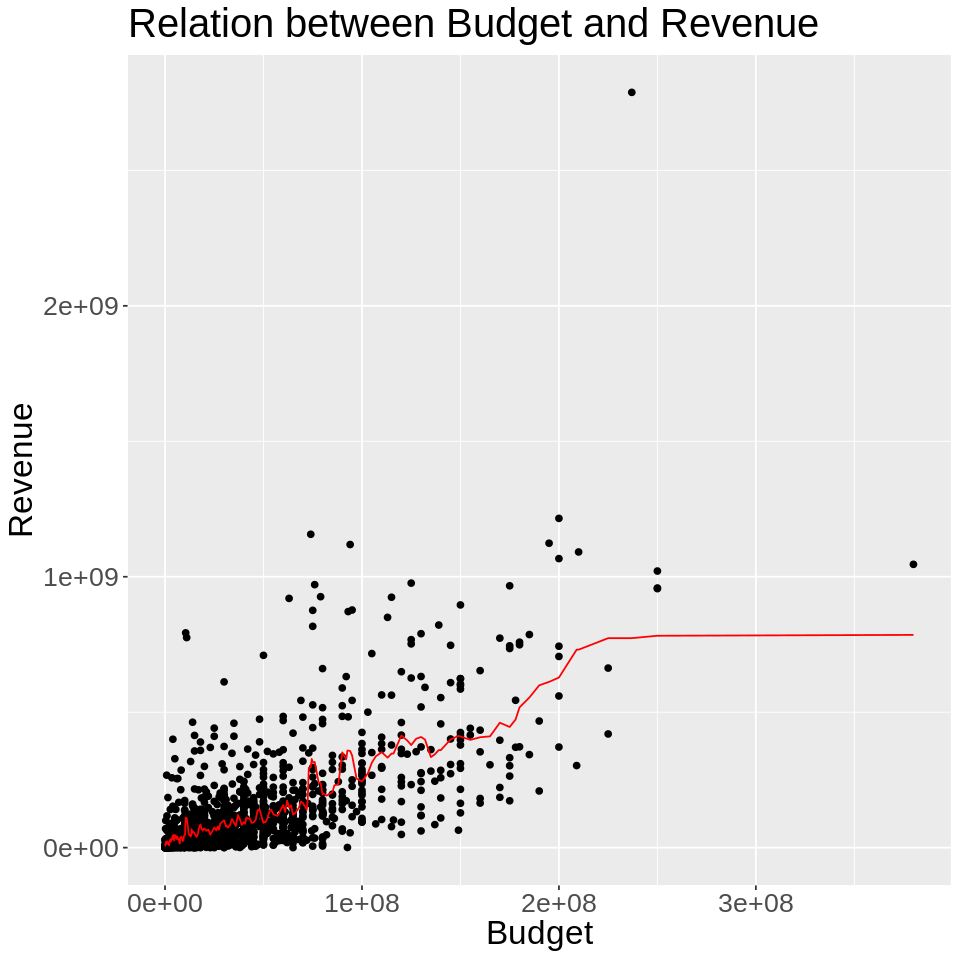

In [44]:
options(repr.plot.width = 8, repr.plot.height = 8)

# your code here
revenue_preds <- revenue_best_fit %>%
                  predict(revenue_train)%>%
                  bind_cols(revenue_train)%>%
                select(.pred, revenue, budget)
revenue_Budget_plot <- ggplot(revenue_preds, aes(x = budget, y = revenue)) +
                geom_point() +
                geom_line (data = revenue_preds, mapping = aes (x = budget, y = .pred), color = "red")+
                xlab ("Budget")+
                ylab("Revenue")+
                ggtitle("Relation between Budget and Revenue")+
                theme(text = element_text(size = 20))

revenue_Budget_plot

### Expected outcomes, significance and discussion:

 We want  to find the profitability of the movie before it is released, and predict the revenue of the movie by some factors. Before a movie is  released, it will go through four or five rounds of test screenings, track the audience’s viewing behavior, and test the audience’s response questionnaires. If the statistical results in the first test screenings are not satisfactory, the director will make corresponding modifications in order to pass the second round of testing. Through data research, we can predict the box office of the movie, and we can adjust the movie to maximize profits and ask if the “big” data of movies have significance?
 
This project centers around studying the profitability of a movie before it is released, predicting revenues based on budget using Knn regression. By analyzing the data set, which consists of 5000 movies from TMDB, as we expected, we found the relationship between the profitability of a movie and the revenues is positive within the budget range of $0 to $2e+08, after that the slope of the budget and the revenue will close to 0, which means the revenue will stay constant as the budget increase.

According to the above data, we find that the revenue of a film is most closely related to the investment cost of the film. Therefore, if we want to make the film more profitable, we have to increase the investment cost of the film. KNN regression is very advantageous because it has strong elasticity to noise and effective data training in the case of large training data.

According to our findings,  the correlation between revenue and budget is strongest. This raises the question, if the budget is high enough, the box office will always be higher, and so will the revenue. So besides increasing the budget, we should think about what other ways we can improve the revenue of the film. According to the research, word of mouth has a strong influence on the box office trend of films. When word of mouth reaches a certain height, the subsequent box office of films will have explosive growth.  When word of mouth falls below a certain level, the box office trend of films will decrease and exit the market quickly. Box office trends largely reflect audience satisfaction with a film. So this raises the question of whether it's more important to invest in a movie, or to focus on the content and depth of the movie.

### Citation

Mueller, Annie. “Why Movies Cost so Much to Make.” Investopedia, Investopedia, 1 Dec. 2021, https://www.investopedia.com/financial-edge/0611/why-movies-cost-so-much-to-make.aspx#:~:text=Movie%20budgets%20can%20average%20around,and%20special%20effects%2C%20and%20marketing. 